In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import os
import numpy as np
import pandas as pd
import graphviz
from IPython.display import Image
from difflib import SequenceMatcher
pd.options.mode.chained_assignment = None

In [ ]:
filenames = next(os.walk("./"), (None, None, []))[2]
anion_file_name = None
cation_file_name = None
if len(filenames) == 0:
  raise BaseException("No files were imported.")
for f in filenames:
  if "Anionic-Cationic" in f:
    anion_file_name = f
    cation_file_name = f
    break
  elif "Anionic" in f:
    anion_file_name = f
  elif "Cationic" in f:
    cation_file_name = f

if anion_file_name is None or cation_file_name is None:
    raise BaseException("Do the name of the files follow the following convention, such that it should contain 'Anionic-Cationic', 'Anionic' or 'Cationic'")

if anion_file_name == cation_file_name:
  a = int(input("Do you wish to run the experiments on both the cations and anions at the same time ? (Enter 1 to continue) "))
  if a != 1:
    anion_file_name = None
    cation_file_name = None
    raise BaseException("Automatically getting file names did not work.\nThere appears to be a file that contains 'Anionic-Cationic' in its name.")
else:
  a = int(input("Do you wish to use the following file with anions ? "+ anion_file_name+ " (Enter 1 to continue) "))
  b = int(input("Do you wish to use the following file with cations ? "+ cation_file_name+ " (Enter 1 to continue) "))
  if a != 1 or b != 1:
    raise BaseException("Automatically getting file names did not work.\n There seems to be multiple filenames that contain 'Anionic' or 'Cationic'")

Vous souhaitez utiliser le fichier suivant pour les anions ? Anionic_16_membranes_VF.csv (Entrez 1 pour continuer) 1
Vous souhaitez utiliser le fichier suivant pour les cations ? Cationic_16_membranes_VF.csv (Entrez 1 pour continuer) 1


In [ ]:
DECALAGE = True

In [ ]:
### DATALOADER

decalage = np.array([34, 22])
decalage_full = 56
is_equal = (anion_file_name == cation_file_name)

anion_file_name = "./" + anion_file_name
cation_file_name = "./" + cation_file_name

def load_data(boolean):
    if boolean:
      df = pd.read_csv(cation_file_name, sep=";")
    else:
      df = pd.read_csv(anion_file_name, sep=";")

    if DECALAGE:
      s = df.shape[0]
      df = df.iloc[DECALAGE*(decalage[int(boolean)]*(1-int(is_equal))+ decalage_full*int(is_equal)):, :]


    l = ['R1 A-', 'R2 A-', 'R3 A-', 'R1 C+', 'R2 C+', 'R3 C+']
    y = df[l]
    y.rename(columns={'R1 A-': 'R1_A', 'R2 A-': 'R2_A',
                      'R3 A-': 'R3_A', 'R1 C+': 'R1_C',
                      'R2 C+': 'R2_C', 'R3 C+': 'R3_C'},
             inplace=True)
    l = l + ['membrane', 'Peptides', 'bend_percent', 'turn_percent']
    df = df.drop(columns=l)
    return df, y

def load_data_mean(boolean):
    """
    Returns the data. We take the mean of the response variable.
    :param boolean: True if we want positive data, False otherwise.  
    :return:
    """
    df, y = load_data(boolean)
    if boolean:
        y_pos = y[['R1_C', 'R2_C', 'R2_C']].mean(axis=1)
        return df, y_pos
    else:
        y_neg = y[['R1_A', 'R2_A', 'R3_A']].mean(axis=1)
        return df, y_neg

def get_peptides_names(boolean):
      if boolean:
        df = pd.read_csv(cation_file_name, sep=";")
      else:
        df = pd.read_csv(anion_file_name, sep=";")

      if DECALAGE:
        df = df.iloc[DECALAGE*(decalage[int(boolean)]*(1-int(is_equal))+ decalage_full*int(is_equal)):, :]
      return (df['membrane'] + ' + ' + df['Peptides'])


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

class SimpleBANN():
    def __init__(self, w, b, c, d):
        assert len(w.shape) == 2, f'Expected w to be of shape (d,h), got {w.shape} (where h = number of hidden neurons).'
        assert len(b.shape) == 1, f'Expected b to be of shape (h), got {b.shape} (where h = number of hidden neurons).'
        assert len(c.shape) == 2, f'Expected c to be of shape (h,1), got {c.shape} (where h = number of hidden neurons).'
        assert len(d) == 1, f'Expected d to be of shape (1), got {d.shape}.'
        self.w, self.b, self.c, self.d = w, b, c, d
        self.epsilon = 1e-10

    def predict(self, x):
        assert len(self.w) == len(x[0]), f'Wrong feature dimension; expected {len(self.w)}, got {len(x[0])}.'
        hidden = np.sign(np.matmul(x, self.w) + self.b + self.epsilon)
        return np.squeeze(np.matmul(hidden, self.c) + self.d)

    def get_hidden(self, x):
        assert len(self.w) == len(x[0]), f'Wrong feature dimension; expected {len(self.w)}, got {len(x[0])}.'
        return (np.sign(np.matmul(x, self.w) + self.b + self.epsilon) + 1)/2

    def get_c_prime(self):
        c_prime = 2*self.c
        d_prime = self.d - self.c.sum()
        return c_prime, d_prime

def load_BANN(type):
    assert type in ['anions','cations'], "Only two permitted choice of model loading: 'anion' and 'cation'."
    w = np.loadtxt(f'models/w_{type}.txt', delimiter=',')
    b = np.loadtxt(f'models/b_{type}.txt', delimiter=',')
    c = np.expand_dims(np.loadtxt(f'models/c_{type}.txt', delimiter=','), 1)
    d = np.array([np.loadtxt(f'models/d_{type}.txt', delimiter=',')])
    return SimpleBANN(w, b, c, d)

# BGN Cation


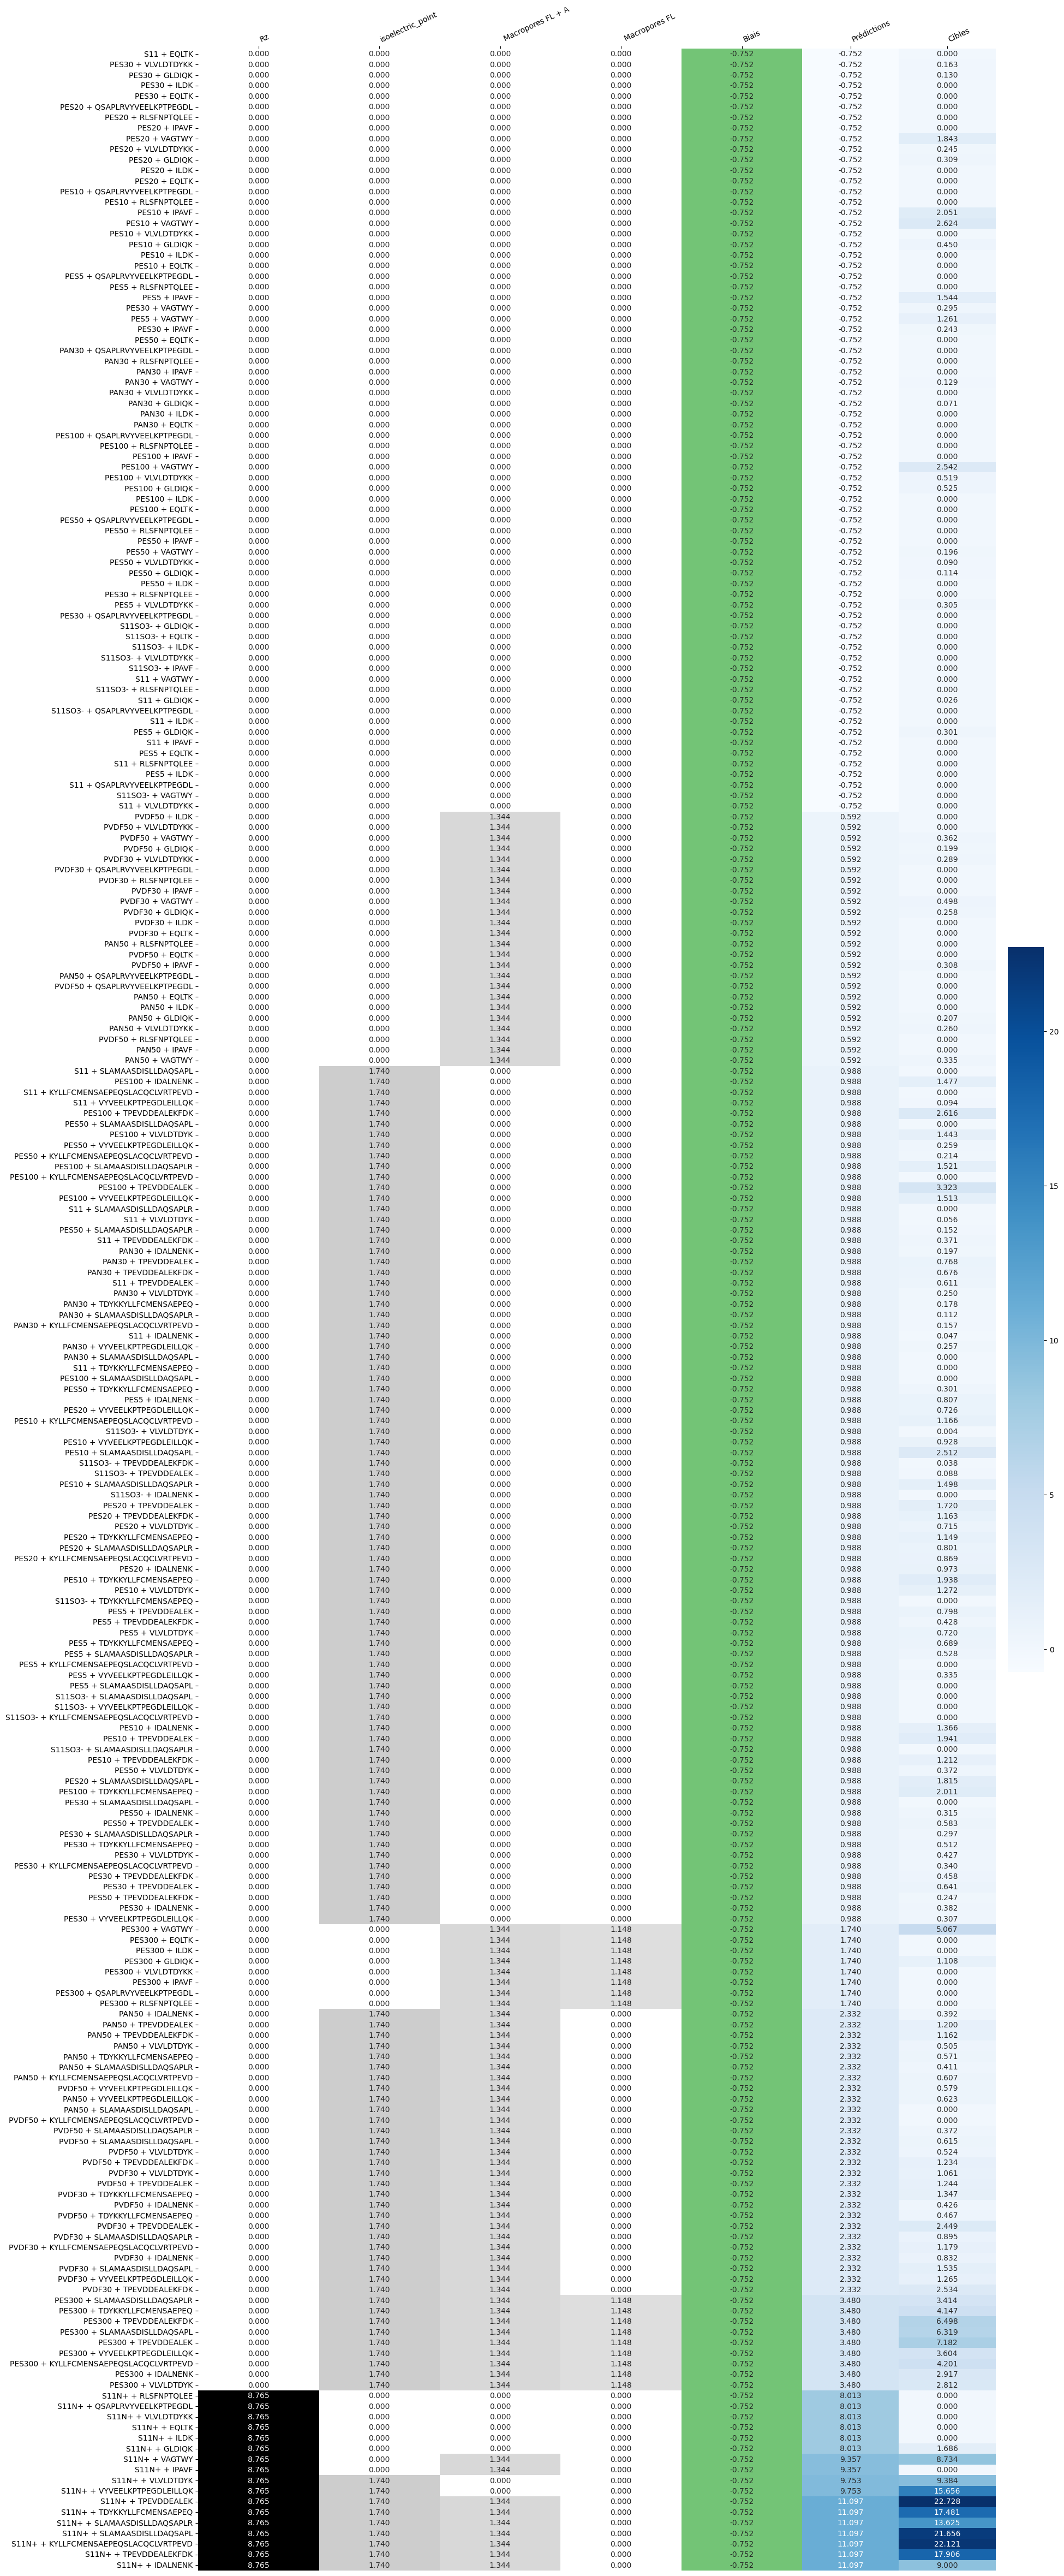

In [ ]:
anion_cation = False
use_all_features = True
sb = load_BANN('cations' if anion_cation else 'anions')

if use_all_features:
  membrane = ['Contact angle', 'hydrophilic pores',
          'Volumetric porosity', 'Zeta-potential', 'Rz', ' Macropores FL']

  peptide = ['mol_weight', 'isoelectric_point',
          'GRAVY', 'm/z_at_pH7.0',
          'Hall Kier Alpha', 'Polar R', 'A', 'D', 'F', 'H',
          'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

  features = membrane + peptide
else:
  if anion_cation:
    features = ['Volumetric porosity', 'L', 'm/z_at_pH7.0', 'Polar R', 'Rz', 'V', 'R', 'Zeta-potential', ' Macropores FL', 'mol_weight', 'Contact angle', 'hydrophilic pores', 'isoelectric_point']
  else:
    features = ['Rz', 'isoelectric_point', 'mol_weight', 'm/z_at_pH7.0', ' Macropores FL', 'A']

X, y = load_data_mean(anion_cation)
X_selected = X[features].values

# get predictions
p = sb.predict(X_selected)
c_prime, d_prime = sb.get_c_prime()
h = sb.get_hidden(X_selected)
h = h * c_prime.squeeze(1)

#get peptide names
peptide_names = get_peptides_names(anion_cation)[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal)) + np.argsort(p)]

# column names
columns = []
for i in range(sb.w.shape[1]):
  index_list = np.where(np.abs(sb.w[:,i]) > 1e-7)[0]
  string = ""
  for index in index_list:
    string += features[index] + " + "
  string = string[:-3]
  columns.append(string)

# get data
df = pd.DataFrame(h[np.argsort(p)], index=peptide_names, columns=columns)
bias = pd.DataFrame(d_prime * np.ones((p.shape[0],1)), columns=["Biais"])
pred_target = pd.DataFrame(np.concatenate((np.expand_dims(p, 1), np.expand_dims(y,1)), axis=1)[np.argsort(p)],columns=["Prédictions", "Cibles"])

#order the columns

order_of_importance = np.argsort(c_prime, axis=None)[::-1]
df = df.iloc[:, order_of_importance]
columns = list(np.array(columns)[order_of_importance])

float_format = ".3f"
fig, axs = plt.subplots(1, 3, figsize=(20,60), gridspec_kw={'width_ratios': [len(columns),1,2]})
h1 = sn.heatmap(df, annot=True, fmt=float_format, ax=axs[0], cbar=False, cmap="binary")
h2 = sn.heatmap(bias,annot=True, fmt=float_format, vmin=d_prime-1, vmax=d_prime+1, yticklabels=False, cbar=False, ax=axs[1],cmap="Greens")
h3 = sn.heatmap(pred_target,annot=True, fmt=float_format, vmax=y.max(),yticklabels=False, ax=axs[2],cmap="Blues")
if True:
  h1.xaxis.tick_top()
  h1.set_xticklabels(h1.get_xticklabels(), rotation=25, ha='left')
  h2.xaxis.tick_top()
  h2.set_xticklabels(h2.get_xticklabels(), rotation=25, ha='left')
  h3.xaxis.tick_top()
  h3.set_xticklabels(h3.get_xticklabels(), rotation=25, ha='left')
else:
  h1.set_xticklabels(h1.get_xticklabels(), rotation=25, ha='right')
  h2.set_xticklabels(h2.get_xticklabels(), rotation=25, ha='right')
  h3.set_xticklabels(h2.get_xticklabels(), rotation=25, ha='right')
fig.subplots_adjust(wspace=0)
if False:
  fig.savefig(f"heatmaps_{('cations' if anion_cation else 'anions')}.pdf",bbox_inches='tight')
else:
  fig.savefig(f"heatmaps_{('cations' if anion_cation else 'anions')}",bbox_inches='tight')

In [ ]:
liste = []
for feature in features:
  for col in columns:
    if feature in col:
      if feature not in liste:
        if len(feature) == 1 and len(col) == 1:
          liste.append(feature)
        elif len(feature) == 1 and len(col) != 1:
          if (feature + " ") in col or col.index(feature) == len(col)-1:
              liste.append(feature)
        else:
          liste.append(feature)
print(liste)

['Rz', 'isoelectric_point', ' Macropores FL', 'A']


In [ ]:
new_data = X[liste].loc[DECALAGE*(decalage[int(anion_cation)]*(1-int(is_equal))+ decalage_full*int(is_equal)) + np.argsort(p)]
separators = -1000 * np.ones((new_data.shape[0],1))
all_data = np.concatenate((separators, new_data.values, separators, df.values, bias.values, pred_target.values), axis=1)
assert 2 + new_data.shape[1] + df.shape[1] + bias.shape[1] + pred_target.shape[1] == all_data.shape[1]
all_columns = ["separator : peptide-membrane features"] + list(new_data.columns) + ["separator : features used in each nodes of model"] + list(df.columns) + list(bias.columns) + list(pred_target.columns)
assert len(all_columns) == all_data.shape[1]
df_all = pd.DataFrame(all_data, index=df.index, columns=all_columns)
df_all

,separator : peptide-membrane features,Rz,isoelectric_point,Macropores FL,A,separator : features used in each nodes of model,Rz,isoelectric_point,Macropores FL + A,Macropores FL,Biais,Prédictions,Cibles
S11 + EQLTK,-1000.0,21.707000,6.100722,25.817083,0.000000,-1000.0,0.00000,0.000000,0.000000,0.0,-0.751685,-0.751685,0.000000
PES30 + VLVLDTDYKK,-1000.0,7.364167,5.929580,11.571342,0.000000,-1000.0,0.00000,0.000000,0.000000,0.0,-0.751685,-0.751685,0.162862
PES30 + GLDIQK,-1000.0,7.364167,5.835682,11.571342,0.000000,-1000.0,0.00000,0.000000,0.000000,0.0,-0.751685,-0.751685,0.130037
PES30 + ILDK,-1000.0,7.364167,5.835682,11.571342,0.000000,-1000.0,0.00000,0.000000,0.000000,0.0,-0.751685,-0.751685,0.000000
PES30 + EQLTK,-1000.0,7.364167,6.100722,11.571342,0.000000,-1000.0,0.00000,0.000000,0.000000,0.0,-0.751685,-0.751685,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S11N+ + SLAMAASDISLLDAQSAPLR,-1000.0,40.594667,4.206904,31.218907,0.250000,-1000.0,8.76466,1.740001,1.343864,0.0,-0.751685,11.096840,13.624613
S11N+ + SLAMAASDISLLDAQSAPL,-1000.0,40.594667,4.050028,31.218907,0.263158,-1000.0,8.76466,1.740001,1.343864,0.0,-0.751685,11.096840,21.655918
S11N+ + KYLLFCMENSAEPEQSLACQCLVRTPEVD,-1000.0,40.594667,4.402487,31.218907,0.068966,-1000.0,8.76466,1.740001,1.343864,0.0,-0.751685,11.096840,22.121244
S11N+ + TPEVDDEALEKFDK,-1000.0,40.594667,4.050028,31.218907,0.071429,-1000.0,8.76466,1.740001,1.343864,0.0,-0.751685,11.096840,17.905607


In [ ]:
df_all.to_excel(f"alldata_{('cation' if anion_cation else 'anion')}.xlsx", columns=all_columns)